In [12]:
from luma.preprocessing.imputer import SimpleImputer
from luma.preprocessing.encoder import OneHotEncoder
from luma.ensemble.forest import RandomForestClassifier
from luma.model_selection.split import TrainTestSplit
from luma.model_selection.search import GridSearchCV
from luma.pipe.pipeline import Pipeline
from luma.visual.eda import CorrelationHeatMap, MissingProportion
from luma.metric.classification import Accuracy, Complex

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load Datasets

In [2]:
train_data = pd.read_csv('data/spaceship/train.csv')
test_data = pd.read_csv('data/spaceship/test.csv')

train_data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


### Remove Redundant Columns

In [3]:
remove_col = ['PassengerId', 'Name', 'Cabin']
train_data.drop(remove_col, axis=1, inplace=True)
test_data.drop(remove_col, axis=1, inplace=True)

train_data

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True
...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False


### Missing Value Proportions

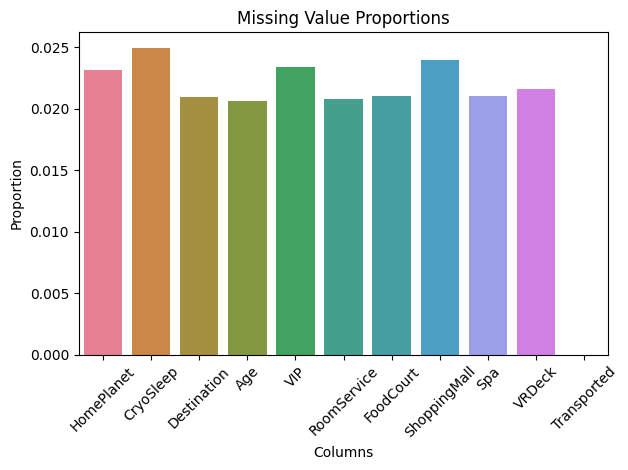

In [4]:
miss = MissingProportion(train_data)
miss.plot()

### Split Original Set into Train and Test Sets

In [5]:
train_data_np = train_data.values
test_data_np = test_data.values

X_train = train_data_np[:, :-1]
X_test = test_data_np

y_train = train_data_np[:, -1].astype(int)

### Handle Missing Values with Pipeline

In [6]:
pipe_pre = Pipeline(models=[
                        ('si', SimpleImputer()),
                        ('en', OneHotEncoder())
                    ],
                    param_dict={
                        'si__strategy': 'mode',
                        'en__features': [0, 2]
                    })

pipe_pre.dump()

Configuration of a pipeline:

[SimpleImputer as 'si']
strategy: mode
statistics: None
_fitted: False

[OneHotEncoder as 'en']
categories_: None
features: [0, 2]
_fitted: False


In [47]:
X_train_pre = pipe_pre.fit_transform(X_train, y_train)[0]
X_test_pre = pipe_pre.fit_transform(X_test, None)[0]

X_train_pre

array([[   1,    0,    0, ...,    0,    0,    0],
       [   1,    0,    0, ...,    0, 2823,    0],
       [   0,    1,    0, ...,    0,    0,    0],
       ...,
       [   0,    0,    1, ...,    0,    0,    0],
       [   0,    1,    0, ...,    0,    0,  523],
       [   1,    0,    0, ...,    0,    0,    0]])

### Correlation Heatmap of Preprocessed Train Set

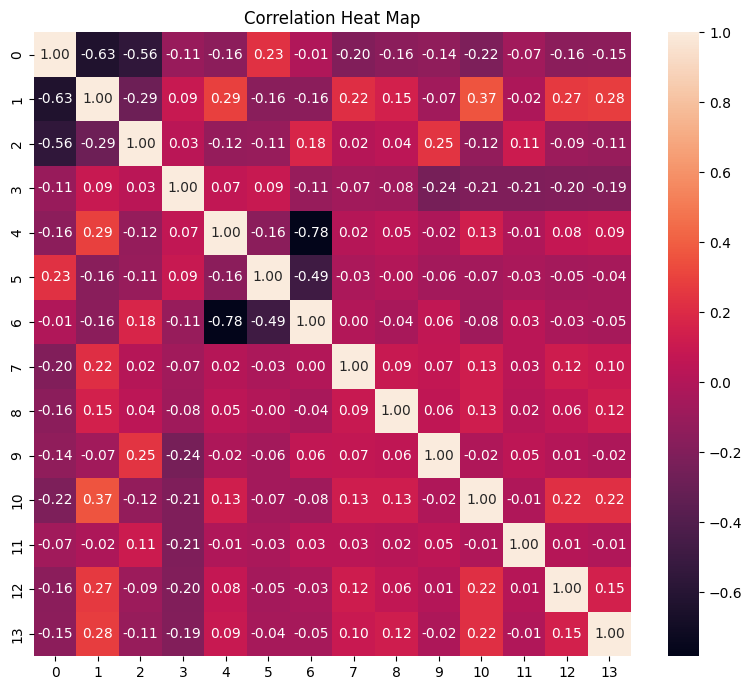

In [8]:
corr = CorrelationHeatMap(pd.DataFrame(X_train_pre))
corr.plot()

### Split Train Set into Another Train and Validation Sets

In [9]:
X_train, X_val, y_train, y_val = TrainTestSplit.split(X_train_pre, y_train,
                                                      test_size=0.3,
                                                      random_state=10)

X_train.shape, X_val.shape

((6086, 14), (2607, 14))

### Random Forest Classifier with GridSeachCV

In [16]:
param_grid = {
    'max_depth': [50, 100, 200],
}

grid = GridSearchCV(model=RandomForestClassifier(),
                    param_grid=param_grid,
                    cv=5,
                    metric=Accuracy,
                    refit=True,
                    verbose=True)

grid.fit(X_train, y_train)

Fitting 5 folds for 3 candidates, totalling 15 fits.

[GridSearchCV] fold 1 - score: 0.789
[GridSearchCV] fold 2 - score: 0.761
[GridSearchCV] fold 3 - score: 0.765
[GridSearchCV] fold 4 - score: 0.767
[GridSearchCV] fold 5 - score: 0.773
[1/3] {'max_depth': 50} - score: 0.771
[GridSearchCV] fold 1 - score: 0.776
[GridSearchCV] fold 2 - score: 0.770
[GridSearchCV] fold 3 - score: 0.776
[GridSearchCV] fold 4 - score: 0.768
[GridSearchCV] fold 5 - score: 0.749
[2/3] {'max_depth': 100} - score: 0.768
[GridSearchCV] fold 1 - score: 0.795
[GridSearchCV] fold 2 - score: 0.772
[GridSearchCV] fold 3 - score: 0.758
[GridSearchCV] fold 4 - score: 0.773
[GridSearchCV] fold 5 - score: 0.767
[3/3] {'max_depth': 200} - score: 0.773

[GridSearchCV] Best params: {'max_depth': 200}
[GridSearchCV] Best score: 0.7730867985422712


### Validation Scores

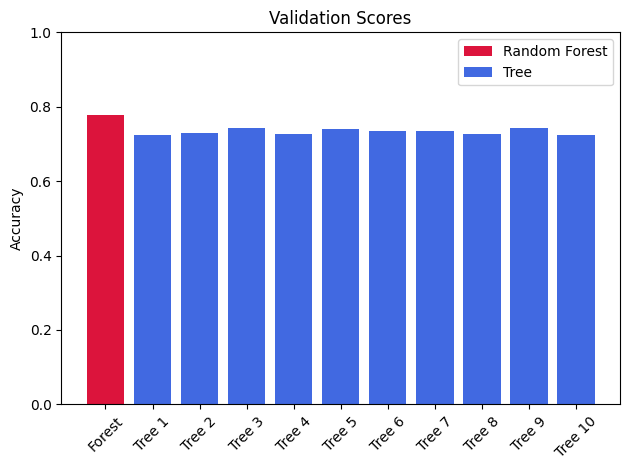

{'accuracy': 0.7775220560030687,
 'precision': 0.7788089713843774,
 'recall': 0.7740199846272099,
 'f1-score': 0.7764070932922129,
 'specificity': 0.781010719754977}

In [44]:
forest = grid.best_model

scores = [forest.score(X_val, y_val)]
for tree in forest.trees:
    scores.append(tree.score(X_val, y_val))
    
plt.bar(0, scores[0], color='crimson', label='Random Forest')
plt.bar(range(1, forest.n_trees + 1), scores[1:], color='royalblue', label='Tree')
plt.xticks(range(forest.n_trees + 1), 
           ['Forest'] + [f'Tree {i + 1}' for i in range(forest.n_trees)],
           rotation=45)
plt.ylabel('Accuracy')
plt.ylim(0.0, 1.0)
plt.title('Validation Scores')
plt.legend()
plt.tight_layout()
plt.show()

Complex.compute(y_true=y_val, y_pred=forest.predict(X_val))

### Predict Test Set

In [54]:
y_test_pred = forest.predict(X_test_pre)
np.bincount(y_test_pred)

array([2116, 2161])

### Export Submission Data

In [66]:
passenger_id = pd.read_csv('data/spaceship/test.csv')['PassengerId'].values

sub = pd.DataFrame({'PassengerId': passenger_id, 
                    'Transported': y_test_pred.astype(bool)})

sub.to_csv('data/spaceship/submission.csv', index=False)
sub

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True
